In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [201]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [76]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\left\\3d3ddaf8_nohash_2.wav', shape=(), dtype=string)


In [202]:
filenames

<tf.Tensor: shape=(8000,), dtype=string, numpy=
array([b'data\\mini_speech_commands\\left\\3d3ddaf8_nohash_2.wav',
       b'data\\mini_speech_commands\\no\\234ab0fb_nohash_0.wav',
       b'data\\mini_speech_commands\\left\\9aa21fa9_nohash_4.wav', ...,
       b'data\\mini_speech_commands\\yes\\300384f0_nohash_0.wav',
       b'data\\mini_speech_commands\\left\\25132942_nohash_3.wav',
       b'data\\mini_speech_commands\\up\\ea356919_nohash_0.wav'],
      dtype=object)>

In [5]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [6]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [7]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

In [165]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [178]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

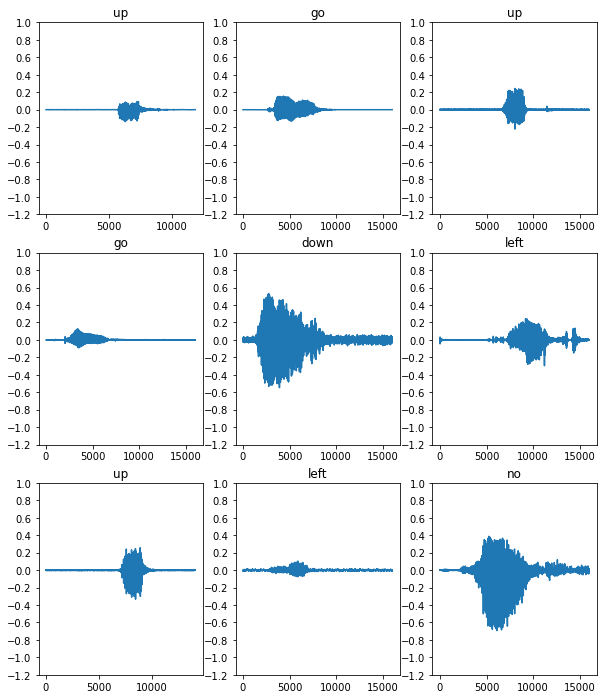

In [179]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [382]:
audio.shape

TensorShape([159, 129, 1])

In [379]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
#product to be the same. length and step = 128??
  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [380]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: up
Waveform shape: (11889,)
Spectrogram shape: (124, 129)
Audio playback


<ipython-input-381-117dc0850110>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


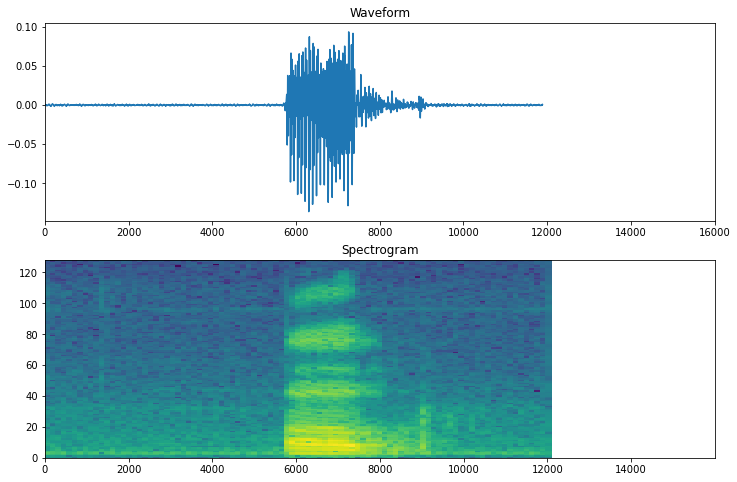

In [381]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [360]:
spectrogram.shape

TensorShape([124, 129])

In [361]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [362]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

<ipython-input-359-117dc0850110>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


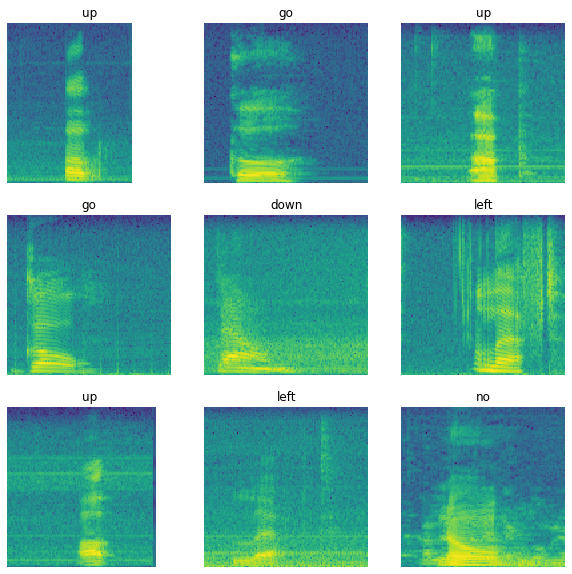

In [363]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [364]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [365]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [366]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [367]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [368]:
spectrogram

<tf.Tensor: shape=(124, 129, 1), dtype=float32, numpy=
array([[[8.5724297e-04],
        [7.5247530e-03],
        [1.2351701e-02],
        ...,
        [9.5993972e-05],
        [8.3888219e-05],
        [1.3136084e-04]],

       [[4.7582835e-03],
        [1.8291807e-02],
        [1.5944466e-02],
        ...,
        [5.7760477e-05],
        [1.9448594e-04],
        [2.4219882e-04]],

       [[7.4962247e-04],
        [6.2067974e-03],
        [7.5501711e-03],
        ...,
        [4.3080439e-05],
        [8.1810460e-05],
        [1.2553297e-05]],

       ...,

       [[1.6114131e-01],
        [1.2466958e+00],
        [1.4350477e+00],
        ...,
        [3.3750938e-04],
        [5.6126574e-04],
        [9.2098862e-04]],

       [[1.1900568e-01],
        [1.1587037e+00],
        [1.6429676e+00],
        ...,
        [5.4686691e-04],
        [3.2157029e-04],
        [1.2655929e-04]],

       [[3.3825086e-03],
        [1.1798389e+00],
        [1.9313337e+00],
        ...,
        [3.7656297e

In [369]:
spectrogram.shape

TensorShape([124, 129, 1])

In [370]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_15 (Resizing)       (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_15 (Normalizat (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)      

In [371]:
input_shape

TensorShape([124, 129, 1])

In [372]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [373]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 15s 148ms/step - loss: 1.7247 - accuracy: 0.3745 - val_loss: 1.2428 - val_accuracy: 0.5838
Epoch 2/10
100/100 [==============================] - 11s 110ms/step - loss: 1.1669 - accuracy: 0.5836 - val_loss: 0.9336 - val_accuracy: 0.7163
Epoch 3/10
100/100 [==============================] - 12s 115ms/step - loss: 0.8825 - accuracy: 0.6842 - val_loss: 0.8019 - val_accuracy: 0.7287
Epoch 4/10
100/100 [==============================] - 11s 114ms/step - loss: 0.7243 - accuracy: 0.7437 - val_loss: 0.7028 - val_accuracy: 0.7525
Epoch 5/10
100/100 [==============================] - 12s 120ms/step - loss: 0.6367 - accuracy: 0.7725 - val_loss: 0.6620 - val_accuracy: 0.7825
Epoch 6/10
100/100 [==============================] - 11s 111ms/step - loss: 0.5530 - accuracy: 0.7992 - val_loss: 0.6090 - val_accuracy: 0.7950
Epoch 7/10
100/100 [==============================] - 11s 113ms/step - loss: 0.4865 - accuracy: 0.8275 - val_loss: 0.6075 - val_ac

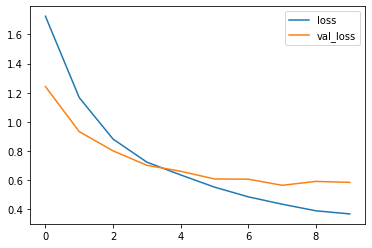

In [374]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [352]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [383]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 86%


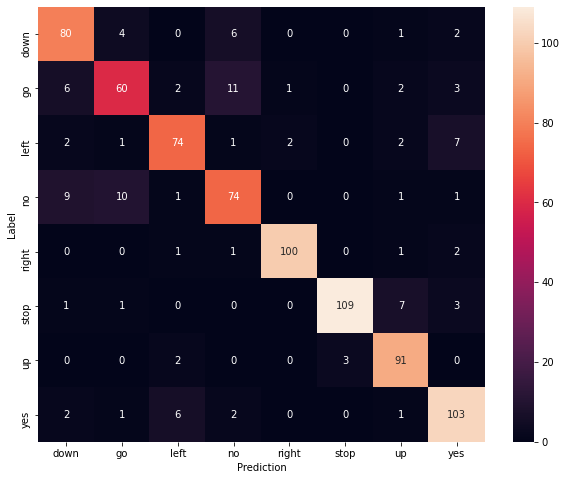

In [384]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

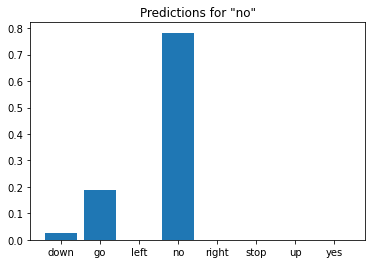

In [385]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()